# 差動関節マニピュレータの逆運動学
Created by Masahiro Furukawa, Aug 18, 2020

Modefied by Tomoki Hirayama ,Sep 29,2020


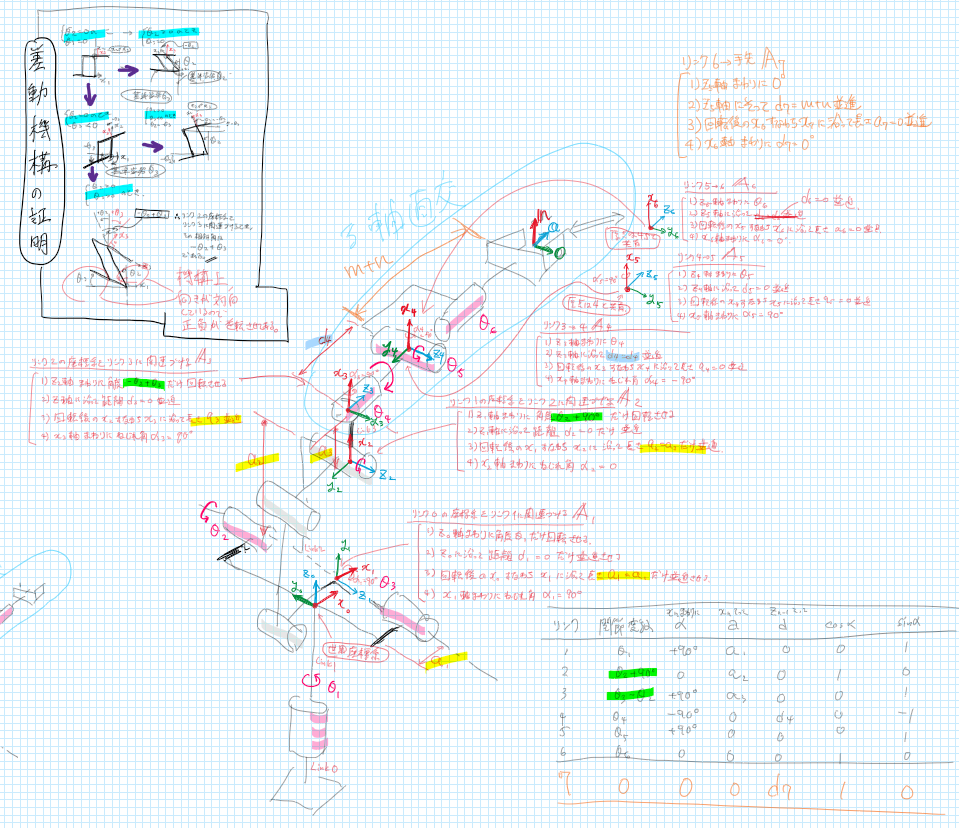

In [1]:
#参考URL -> https://qiita.com/tibigame/items/61cecf86fc978628bfee
#参考図書 -> ポールのロボット・マニピュレータ

import numpy as np
import sympy as sym
sym.init_printing()
Pi = sym.S.Pi # 円周率

#sympyの円周率の方を使うことをすすめる（こっちの方が量子化誤差が大きくなる．numpyも同様に大きい）
import math
pi = math.pi

# 角度変数
(J_1,J_2,J_3,J_4,J_5,J_6) = sym.symbols('J_1,J_2,J_3,J_4,J_5,J_6')

# リンクパラメータ
(a_1,a_2,a_3,d_4,d_7) = sym.symbols('a_1,a_2,a_3,d_4,d_7')

# リンクパラメータ
(j,a,d,alpha) = sym.symbols('j,a,d,alpha')

# T6
(n_x, n_y, n_z, o_x, o_y, o_z, a_x, a_y, a_z, p_x, p_y, p_z) = sym.symbols('n_x, n_y, n_z, o_x, o_y, o_z, a_x, a_y, a_z, p_x, p_y, p_z')

In [2]:
#sin.cosの簡易記述用
def S(a):
    return sym.sin(a)

def C(a):
    return sym.cos(a)

In [3]:
#回転・並進行列
def rotx(a):
    return sym.Matrix([[1, 0, 0, 0], [0, C(a), -S(a), 0], [0, S(a), C(a), 0], [0, 0, 0, 1]])

def roty(a):
    return sym.Matrix([[C(a), 0, S(a), 0], [0, 1, 0, 0], [-S(a), 0, C(a), 0], [0, 0, 0, 1]])

def rotz(a):
    return sym.Matrix([[C(a), -S(a), 0, 0], [S(a), C(a), 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def trans(x, y, z):
    return sym.Matrix([[1, 0, 0, x], [0, 1, 0, y], [0, 0, 1, z], [0, 0, 0, 1]])

# DH matrix 
def DH(j, alpha, a, d):
    return rotz(j)*trans(a,0,d)*rotx(alpha)

# inverse DH matrix
def DHi(j, alpha, a, d):
    return rotx(-alpha)*trans(-a,0,-d)*rotz(-j)

In [4]:
# target項を式eqからくくり出すための関数
def obs(eq, target):
    sol = sym.solve(eq, target)
    for i  in range(len(sol)):
        display( sym.Eq(target,  sol[i]))
    print( str(len(sol)) +' equation(s) in total')
    return sol

### DH法に基づく座標系間の関係表現

|座標系 i|Z_i-1軸回りに角度θ_i|X_i軸周りにねじれ角α_iだけ回転|回転後のX_i-1 (=X_i)に沿って長さa_iだけ並進|Z_i-1に沿って距離d_iだけ並進|
|-|-|-|-|-|
|1|$J_1$|$\pi/2$|$a_1$|0|
|2|$J_2+\pi/2$|0|$a_2$|0|
|3|$J_3-J_2$|$\pi/2$|$a_3$|0|
|4|$J_4$|$-\pi/2$|0|$d_4$|
|5|$J_5$|$\pi/2$|0|0|
|6|$J_6$|0|0|0|
|7|0|0|0|$d_7$|

###変換行列

In [5]:
easy=False
if(easy):
    A1=sym.trigsimp( DH (        J_1,   Pi/2, 0, 0))
    A3=sym.trigsimp( DH (  J_3 - J_2,   Pi/2, 0, 0))
    A1i=sym.trigsimp( DHi (      J_1,   Pi/2, 0, 0))
    A3i=sym.trigsimp( DHi (J_3 - J_2,   Pi/2, 0, 0))
else:
    A1=sym.trigsimp( DH (        J_1,   Pi/2, a_1, 0))
    A3=sym.trigsimp( DH (  J_3 - J_2,   Pi/2, a_3, 0))
    # inverse matrix
    A1i=sym.trigsimp( DHi (      J_1,   Pi/2, a_1, 0))
    A3i=sym.trigsimp( DHi (J_3 - J_2,   Pi/2, a_3, 0))

A2=sym.trigsimp( DH (J_2+ Pi/2,    0,  a_2,   0))
A4=sym.trigsimp( DH (J_4,      -Pi/2,    0, d_4))
A5=sym.trigsimp( DH (J_5,       Pi/2,    0,   0))
A6=sym.trigsimp( DH (J_6,          0,    0,   0))

A7=sym.trigsimp( DH (0,            0,0,     d_7))

# inverse matrix
A2i=sym.trigsimp( DHi (J_2+ Pi/2,     0, a_2,   0))
A4i=sym.trigsimp( DHi (J_4,       -Pi/2,   0, d_4))
A5i=sym.trigsimp( DHi (J_5,        Pi/2,   0,   0))
A6i=sym.trigsimp( DHi (J_6,           0,   0,   0))
A7i=sym.trigsimp( DHi (0,            0,0,     d_7))


In [6]:
A7

⎡1  0  0  0 ⎤
⎢           ⎥
⎢0  1  0  0 ⎥
⎢           ⎥
⎢0  0  1  d₇⎥
⎢           ⎥
⎣0  0  0  1 ⎦

In [7]:
ret = A7i*A7
sym.trigsimp(ret)

⎡1  0  0  0⎤
⎢          ⎥
⎢0  1  0  0⎥
⎢          ⎥
⎢0  0  1  0⎥
⎢          ⎥
⎣0  0  0  1⎦

###逆運動学

In [8]:
T7=sym.Matrix([[n_x, o_x, a_x, p_x], [n_y, o_y, a_y, p_y], [n_z, o_z, a_z, p_z], [0, 0, 0, 1]])
T7

⎡nₓ   oₓ   aₓ   pₓ ⎤
⎢                  ⎥
⎢n_y  o_y  a_y  p_y⎥
⎢                  ⎥
⎢n_z  o_z  a_z  p_z⎥
⎢                  ⎥
⎣ 0    0    0    1 ⎦

In [9]:
# forward kinematics
A67     = sym.trigsimp(             A6*A7 )
A567    = sym.trigsimp(          A5*A6*A7 )
A4567   = sym.trigsimp(       A4*A5*A6*A7 )
A34567  = sym.trigsimp(    A3*A4*A5*A6*A7 )
A234567 = sym.trigsimp( A2*A3*A4*A5*A6*A7 )
T   = sym.trigsimp(  A1*A2*A3*A4*A5*A6*A7 )

In [10]:
T

⎡((sin(J₁)⋅sin(J₄) - sin(J₃)⋅cos(J₁)⋅cos(J₄))⋅cos(J₅) - sin(J₅)⋅cos(J₁)⋅cos(J₃
⎢                                                                             
⎢(-(sin(J₁)⋅sin(J₃)⋅cos(J₄) + sin(J₄)⋅cos(J₁))⋅cos(J₅) - sin(J₁)⋅sin(J₅)⋅cos(J
⎢                                                                             
⎢                                (-sin(J₃)⋅sin(J₅) + cos(J₃)⋅cos(J₄)⋅cos(J₅))⋅
⎢                                                                             
⎣                                                                      0      

))⋅cos(J₆) + (sin(J₁)⋅cos(J₄) + sin(J₃)⋅sin(J₄)⋅cos(J₁))⋅sin(J₆)   -((sin(J₁)⋅
                                                                              
₃))⋅cos(J₆) + (sin(J₁)⋅sin(J₃)⋅sin(J₄) - cos(J₁)⋅cos(J₄))⋅sin(J₆)  -(-(sin(J₁)
                                                                              
cos(J₆) - sin(J₄)⋅sin(J₆)⋅cos(J₃)                                             
                                                   

### 順運動学計算用Cソースコードを得る

In [11]:
# Masahiro Furukawa
# Aug, 17, 2020
#
# refernce : https://qiita.com/JmpM/items/4bea4997aaf406cca3b4

# Cソースを得る
for ii in range(4):
    for jj in range(4):
        idx = jj*4+ii
        code = sym.ccode(T[idx],assign_to=('Trans['+str(jj)+']['+str(ii)+']'), standard='C89')
        print(code)
    print()

Trans[0][0] = ((sin(J_1)*sin(J_4) - sin(J_3)*cos(J_1)*cos(J_4))*cos(J_5) - sin(J_5)*cos(J_1)*cos(J_3))*cos(J_6) + (sin(J_1)*cos(J_4) + sin(J_3)*sin(J_4)*cos(J_1))*sin(J_6);
Trans[1][0] = (-(sin(J_1)*sin(J_3)*cos(J_4) + sin(J_4)*cos(J_1))*cos(J_5) - sin(J_1)*sin(J_5)*cos(J_3))*cos(J_6) + (sin(J_1)*sin(J_3)*sin(J_4) - cos(J_1)*cos(J_4))*sin(J_6);
Trans[2][0] = (-sin(J_3)*sin(J_5) + cos(J_3)*cos(J_4)*cos(J_5))*cos(J_6) - sin(J_4)*sin(J_6)*cos(J_3);
Trans[3][0] = 0;

Trans[0][1] = -((sin(J_1)*sin(J_4) - sin(J_3)*cos(J_1)*cos(J_4))*cos(J_5) - sin(J_5)*cos(J_1)*cos(J_3))*sin(J_6) + (sin(J_1)*cos(J_4) + sin(J_3)*sin(J_4)*cos(J_1))*cos(J_6);
Trans[1][1] = -(-(sin(J_1)*sin(J_3)*cos(J_4) + sin(J_4)*cos(J_1))*cos(J_5) - sin(J_1)*sin(J_5)*cos(J_3))*sin(J_6) + (sin(J_1)*sin(J_3)*sin(J_4) - cos(J_1)*cos(J_4))*cos(J_6);
Trans[2][1] = -(-sin(J_3)*sin(J_5) + cos(J_3)*cos(J_4)*cos(J_5))*sin(J_6) - sin(J_4)*cos(J_3)*cos(J_6);
Trans[3][1] = 0;

Trans[0][2] = (sin(J_1)*sin(J_4) - sin(J_3)*cos(J_1)*cos(J_4)

###Inverse Kinematics

In [13]:
T17 = sym.trigsimp(                      A1i*T7 ) #  eq(3.70)
T27 = sym.trigsimp(                  A2i*A1i*T7 ) #  eq(3.71)
T37 = sym.trigsimp(              A3i*A2i*A1i*T7 ) #  eq(3.72)
T47 = sym.trigsimp(          A4i*A3i*A2i*A1i*T7 ) #  eq(3.73)
T57 = sym.trigsimp(      A5i*A4i*A3i*A2i*A1i*T7 ) #  eq(3.74)
T67 = sym.trigsimp(  A6i*A5i*A4i*A3i*A2i*A1i*T7 )

In [14]:
A1iT7 = T17
for idx in range(12):
    display(sym.simplify ( sym.expand( sym.Eq( A1iT7[idx], A234567[idx])) ) )

###J1について

J1が使われている式を抽出

In [15]:
for idx in  [10,11]:
    display(sym.simplify ( sym.expand( sym.Eq( A1iT7[idx], A234567[idx])) ) )

2式に1式を代入すると

In [16]:
display(sym.simplify ( sym.expand( sym.Eq( d_7*A1iT7[10], A1iT7[11])) ) )

整理すると

In [17]:
eqJ1=sym.simplify ( sym.expand( sym.Eq( d_7*A1iT7[10]/C(J_1), A1iT7[11]/C(J_1))) )
#eq =sym.simplify((d_7*A1iT7[10] - A1iT7[11])/C(J_1))
display(eqJ1)

よってJ1は次のように計算できます

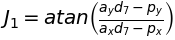

'where p_x != 0'

In [18]:
sol=sym.solve(eqJ1, J_1)
for i  in range(len(sol)):  
        display( sym.simplify(sym.Eq(J_1,  sol[i])) ,  'where p_x != 0')
sol_J1 = sol

###J2,J3について

J2,J3が利用されている式を抽出

In [19]:
for idx in [3,2,7,6]:
    display(sym.simplify ( sym.expand( sym.Eq( A1iT7[idx], A234567[idx])) ) )

ここで，式1について,右辺d7の項の置き換えが可能で

In [20]:
display(sym.simplify ( sym.expand( sym.Eq( A1iT7[3]-d_7*A1iT7[2], A234567[3]-d_7*A234567[2])) ) )

同様に式2についても右辺d7の項の置き換えが可能で

In [21]:
display(sym.simplify ( sym.expand( sym.Eq( A1iT7[7]-d_7*A1iT7[6], A234567[7]-d_7*A234567[6])) ) )

これにより，J2J3に関する等式が次のように得られる


In [22]:
j23eq0=sym.simplify ( sym.expand(sym.Eq( A1iT7[3]-d_7*A1iT7[2], A234567[3]-d_7*A234567[2])))
j23eq1=sym.simplify ( sym.expand(sym.Eq( A1iT7[7]-d_7*A1iT7[6], A234567[7]-d_7*A234567[6])))
for t in [j23eq0,j23eq1]:
  display(t)

J1は既知であるから，1式右辺をLと置くと，


In [23]:
L = sym.symbols('L')
eqJ23=sym.Eq(j23eq0.lhs, L)
#display(sym.trigsimp(sym.expand(sym.Eq(j23eq0.rhs, L))))
display(sym.trigsimp(sym.expand(eqJ23)))

sin(J2)について解くと

In [28]:
SJ2=obs(eqJ23,S(J_2))[0]

1 equation(s) in total


cos(J2)について解くと

In [29]:
CJ2=obs(j23eq1,C(J_2))[0]

1 equation(s) in total


C(J_2)^2 + S(J_2)^2 =1であることから

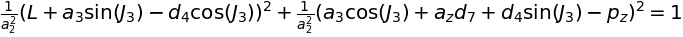

In [30]:
j3eq = sym.trigsimp(sym.Eq((pow(SJ2,2)+pow(CJ2,2)),1))
display(j3eq)

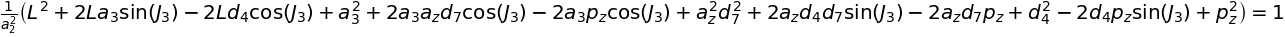

In [31]:
display(sym.collect(sym.trigsimp(j3eq.expand()), [C(J_3),S(J_3)]))

J3について解くと

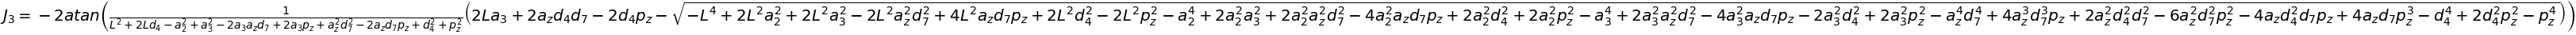

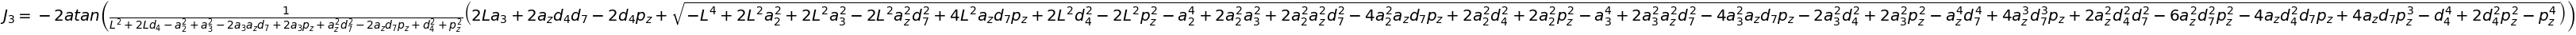

2 equation(s) in total


In [33]:
target = J_3
sol_J3 = obs(j3eq, target)
sol_L = L

In [41]:
# Masahiro Furukawa
# Aug, 21, 2020
#
# refernce : https://qiita.com/JmpM/items/4bea4997aaf406cca3b4

sol_L = j23eq0.rhs

# J3 に対するCソースを得る
code = sym.ccode(sol_L, assign_to=('L'), standard='C89')
print("// constant L \n"  + code + "\n")

for ii in range(len(sol_J3)):
    code = sym.ccode(sol_J3[ii], assign_to=('J3'), standard='C89')
    print("// Solusion #"+ str(ii) +"\n"  + code + "\n")

// constant L 
L = -a_1 - a_x*d_7*cos(J_1) - a_y*d_7*sin(J_1) + p_x*cos(J_1) + p_y*sin(J_1);

// Solusion #0
J3 = -2*atan((2*L*a_3 + 2*a_z*d_4*d_7 - 2*d_4*p_z - sqrt(-pow(L, 4) + 2*pow(L, 2)*pow(a_2, 2) + 2*pow(L, 2)*pow(a_3, 2) - 2*pow(L, 2)*pow(a_z, 2)*pow(d_7, 2) + 4*pow(L, 2)*a_z*d_7*p_z + 2*pow(L, 2)*pow(d_4, 2) - 2*pow(L, 2)*pow(p_z, 2) - pow(a_2, 4) + 2*pow(a_2, 2)*pow(a_3, 2) + 2*pow(a_2, 2)*pow(a_z, 2)*pow(d_7, 2) - 4*pow(a_2, 2)*a_z*d_7*p_z + 2*pow(a_2, 2)*pow(d_4, 2) + 2*pow(a_2, 2)*pow(p_z, 2) - pow(a_3, 4) + 2*pow(a_3, 2)*pow(a_z, 2)*pow(d_7, 2) - 4*pow(a_3, 2)*a_z*d_7*p_z - 2*pow(a_3, 2)*pow(d_4, 2) + 2*pow(a_3, 2)*pow(p_z, 2) - pow(a_z, 4)*pow(d_7, 4) + 4*pow(a_z, 3)*pow(d_7, 3)*p_z + 2*pow(a_z, 2)*pow(d_4, 2)*pow(d_7, 2) - 6*pow(a_z, 2)*pow(d_7, 2)*pow(p_z, 2) - 4*a_z*pow(d_4, 2)*d_7*p_z + 4*a_z*d_7*pow(p_z, 3) - pow(d_4, 4) + 2*pow(d_4, 2)*pow(p_z, 2) - pow(p_z, 4)))/(pow(L, 2) + 2*L*d_4 - pow(a_2, 2) + pow(a_3, 2) - 2*a_3*a_z*d_7 + 2*a_3*p_z + pow(a_z, 2)*pow(d_7, 2) 

J3が計算できたので，J2も計算することができる


In [42]:
sol_J2 = obs(j23eq1,J_2)

2 equation(s) in total


In [43]:
for ii in range(len(sol_J2)):
    code = sym.ccode(sol_J2[ii], assign_to=('J2'), standard='C89')
    print("// Solusion #"+ str(ii) +"\n"  + code + "\n")

// Solusion #0
J2 = -acos(-(a_3*cos(J_3) + a_z*d_7 + d_4*sin(J_3) - p_z)/a_2) + 2*M_PI;

// Solusion #1
J2 = acos((-a_3*cos(J_3) - a_z*d_7 - d_4*sin(J_3) + p_z)/a_2);



###J5について

In [45]:
A3iA2iA1iT7 = A3i*A2i*A1i*T7
for idx in range(12):
    display(sym.simplify ( sym.expand( sym.Eq( A3iA2iA1iT7[idx], A4567[idx])) ) )

上記10番目の式から

In [47]:
j5eq=sym.simplify ( sym.expand( sym.Eq( A3iA2iA1iT7[10], A4567[10])) ) 
display(j5eq)

In [48]:
sol_J5 = obs(j5eq, J_5)

2 equation(s) in total


In [49]:
# J5 に対するCソースを得る
for ii in range(len(sol_J5)):
    code = sym.ccode(sol_J5[ii], assign_to=('J5'), standard='C89')
    print("// Solusion #"+ str(ii) +"\n"  + code + "\n")

// Solusion #0
J5 = -acos(a_x*cos(J_1)*cos(J_3) + a_y*sin(J_1)*cos(J_3) + a_z*sin(J_3)) + 2*M_PI;

// Solusion #1
J5 = acos(a_x*cos(J_1)*cos(J_3) + a_y*sin(J_1)*cos(J_3) + a_z*sin(J_3));



###J4について

In [53]:
#A2iA1iT7 = A2i*A1i*T7
#for idx in range(12):
#    display(sym.simplify ( sym.expand( sym.Eq( A2iA1iT7[idx], A34567[idx])) ) )
j4eq = sym.simplify ( sym.Eq( A3iA2iA1iT7[6], A4567[6]))
display(j4eq) 

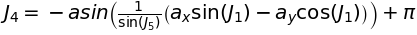

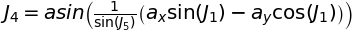

2 equation(s) in total


In [54]:
sol_J4 = obs(j4eq, J_4)

In [55]:
# J4 に対するCソースを得る
for ii in range(len(sol_J4)):
    code = sym.ccode(sol_J4[ii], assign_to=('J4'), standard='C89')
    print("// Solusion #"+ str(ii) +"\n"  + code + "\n")

// Solusion #0
J4 = -asin((a_x*sin(J_1) - a_y*cos(J_1))/sin(J_5)) + M_PI;

// Solusion #1
J4 = asin((a_x*sin(J_1) - a_y*cos(J_1))/sin(J_5));



###j6

In [57]:
A5iA4iA3iA2iA1iT7 = A5i*A4i*A3i*A2i*A1i*T7
for idx in range(12):
    display(sym.simplify ( sym.expand( sym.Eq( A5iA4iA3iA2iA1iT7[idx], A67[idx])) ) )

In [59]:
j6eq=sym.simplify ( sym.expand( sym.Eq( A5iA4iA3iA2iA1iT7[5], A67[5])) ) 
display(j6eq)

In [60]:
sol_J6 = obs(j6eq, J_6)

2 equation(s) in total


In [61]:
# J6 に対するCソースを得る
for ii in range(len(sol_J6)):
    code = sym.ccode(sol_J6[ii], assign_to=('J6'), standard='C89')
    print("// Solusion #"+ str(ii) +"\n"  + code + "\n")

// Solusion #0
J6 = -acos(o_x*sin(J_1)*cos(J_4) + o_x*sin(J_3)*sin(J_4)*cos(J_1) + o_y*sin(J_1)*sin(J_3)*sin(J_4) - o_y*cos(J_1)*cos(J_4) - o_z*sin(J_4)*cos(J_3)) + 2*M_PI;

// Solusion #1
J6 = acos(o_x*sin(J_1)*cos(J_4) + o_x*sin(J_3)*sin(J_4)*cos(J_1) + o_y*sin(J_1)*sin(J_3)*sin(J_4) - o_y*cos(J_1)*cos(J_4) - o_z*sin(J_4)*cos(J_3));

